<h1 align="center">Practical Task on Transfer Learning</h1>


###  [Task 1: Load and Modify a Pre-trained Model](#task1)

- Use TensorFlow or PyTorch to load a pre-trained model (e.g., VGG16, ResNet50, or MobileNet) without the top classification layer.
- Print the model summary.
- Add a new fully connected layer (or layers) suitable for your chosen classification task (e.g., CIFAR-10, Fashion MNIST, or any custom dataset).
- Ensure the output layer has the correct number of classes.

### [Task 2: Data Preparation](#task2)

- Choose a small dataset (e.g., CIFAR-10 or Fashion MNIST).
- Perform the following preprocessing steps:
  - Normalize the images to the range [0, 1].
  - Apply data augmentation techniques (e.g., rotation, flipping, zooming).

### [Task 3: Train the Model](#task3)

- Freeze the layers of the pre-trained model so that their weights are not updated during training.
- Compile the model with an appropriate optimizer and loss function.
- Train the model on your prepared dataset. Use a validation split to monitor performance.

### [Task 4: Evaluate the Model](#task4)

- After training, evaluate your model on a separate test set.
- Report the model’s accuracy, loss, and any other relevant metrics (e.g., confusion matrix).

### [Task 5: Fine-tuning](#task5)

- After initial training, unfreeze a few of the top layers of the pre-trained model.
- Retrain the model with a lower learning rate.
- Observe if performance improves.
- Report the results.


<a id="task2"></a>
## Task 2 solution

In [25]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tensorflow.keras.applications import MobileNetV2
from IPython.display import display, HTML
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import os
import requests
import warnings
warnings.filterwarnings('ignore')

In [2]:
datasets, info = tfds.load(
    name='fashion_mnist',       
    with_info=True,              
    as_supervised=True,      
   # split=['train', 'test']  
    split='train+test'
)

The `tfds.load` function is used to load the "fashion_mnist" dataset from TensorFlow Datasets (TFDS). This function call is configured with several options:
- `name='fashion_mnist'`: Specifies the name of the dataset to be loaded, in this case, the Fashion MNIST dataset.
- `with_info=True`: This option requests that metadata describing the dataset be loaded along with the dataset itself. The metadata includes details such as the number of classes, the shape of the images, and other dataset-specific information which is crucial for understanding and effectively utilizing the dataset.
- `as_supervised=True`: Indicates that the dataset should be loaded in a supervised format, i.e., each element in the dataset will consist of a tuple with two items: an input and its corresponding label. This is particularly useful for training models where input-label pairs are needed.
- `split=['train', 'test']`: Defines the specific splits of the dataset to load. This includes the 'train' split and the 'test' split, which are commonly used to train models and then evaluate their performance on unseen data, respectively.

Upon execution, this function returns two main components:
- `datasets`: A dictionary containing the loaded 'train' and 'test' datasets as specified in the `split` parameter. Each dataset can be accessed using its respective key ('train' or 'test'), allowing for easy manipulation and usage during model training and testing phases.
- `info`: An object containing detailed metadata about the 'fashion_mnist' dataset. This includes information that can be used to understand more about the dataset structure and to configure the model accordingly, such as the format of the data, the number of samples in each split, and label classes among other details.


### Some sample images from the training dataset

2024-10-10 21:49:59.121412: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-10 21:49:59.126192: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


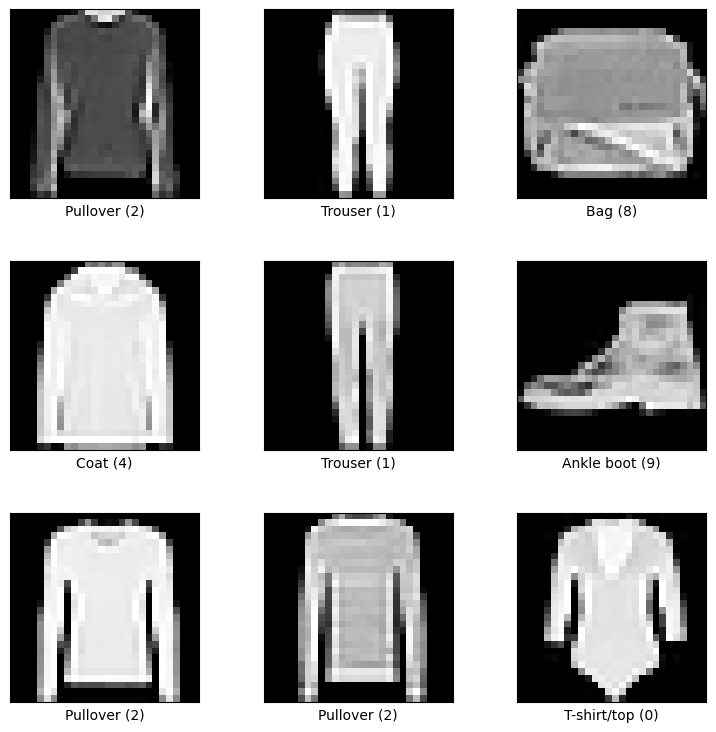

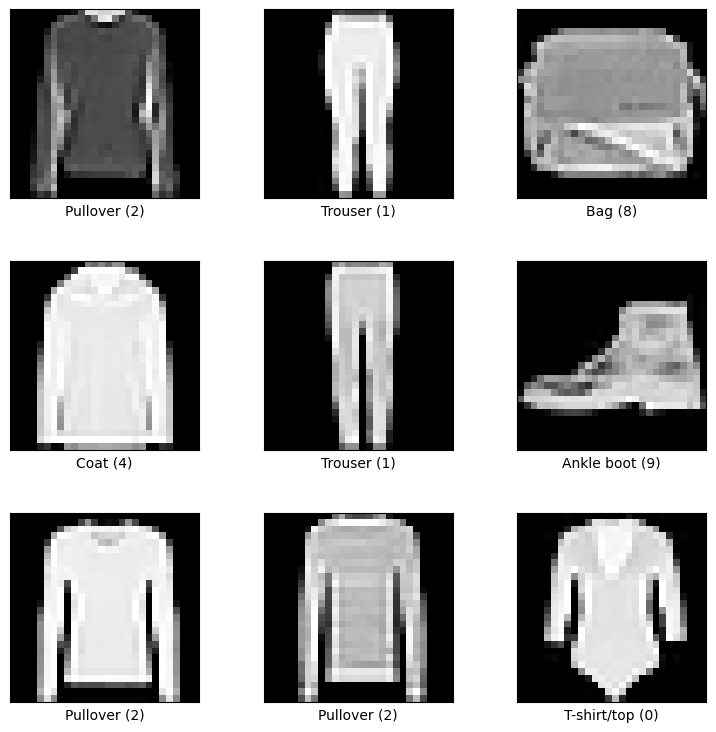

In [3]:
info_train,train = tfds.load(name='fashion_mnist', with_info=True, split='train')
tfds.show_examples(info_train,train)

## Dataset information

In [4]:
def display_dataset_info(info):
    name = info.name
    description = info.description.replace('\n', '<br>') 
    version = info.version
    num_examples = info.splits['train'].num_examples + info.splits['test'].num_examples
    features = info.features
    homepage = info.homepage
    html_content = f"""
    <h2>{name} Dataset Information</h2>
    <p><strong>Description:</strong> {description}</p>
    <p><strong>Version:</strong> {version}</p>
    <p><strong>Total Examples:</strong> {num_examples}</p>
    <p><strong>Homepage:</strong> <a href="{homepage}" target="_blank">{homepage}</a></p>
    <h3>Features:</h3>
    <ul>
    """
    for feature, ftype in features.items():
        html_content += f"<li>{feature}: {ftype}</li>"
    html_content += "</ul>"
    num_classes = info.features['label'].num_classes
    class_names = info.features['label'].names

    html_content += f"<p><strong>Number of Classes:</strong> <span style='color:navy;'>{num_classes}</span></p>"
    html_content += "<p><strong>Class Names:</strong></p><ul>"
    for name in class_names:
        html_content += f"<li style='color:deeppink;'>{name}</li>"
    html_content += "</ul>"
    display(HTML(html_content))
display_dataset_info(info)

##  Split the dataset into training, testing, and validation 

The Fashion MNIST dataset contains a total of 70,000 images.Therefore we split as follows: 
<br> 
- Training set: 54,000 <br>
- Validation set: 6,000<br>
- Test set: 10,000<br>

In [7]:
total_size = len(list(datasets))
print("Total size of dataset:", total_size)

Total size of dataset: 70000


In [10]:
#dataset=datasets[0].concatenate(datasets[1])
dataset = datasets.shuffle(70000)  


val_set = dataset.take(6000)  # Take 6000 for validation
test_set = dataset.skip(6000).take(10000)  # Skip 6000, then take 10000 for test
train_set = dataset.skip(16000).take(54000)  # Skip the first 16000 (6000 val + 10000 test) to use the rest for training


def process_dataset(dataset):
    try:
        for example in dataset:  
            pass 
    except tf.errors.OutOfRangeError:
        print("Reached the end of the dataset.")

val_size = len(list(val_set))
test_size = len(list(test_set))
train_size = len(list(train_set))

print("Validation set size:", val_size)
print("Test set size:", test_size)
print("Training set size:", train_size)

Validation set size: 6000
Test set size: 10000
Training set size: 54000


## Data Preprocessing

In [11]:
def normalization(image, label):
    """Normalize images and apply one-hot encoding to labels."""
    image = tf.cast(image, tf.float32) / 255.0  # Many tenserflow operations expect floating point numbers
    image = tf.image.resize(image, [224, 224])  # Resize the image to 224x224
    label = tf.one_hot(label, depth=10)         # Apply one-hot encoding with 10 classes
    return image, label

In [12]:
def augmentation(image, label):
    """Applies data augmentation."""
    # Random flips and rotations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random zoom
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness

    return image, label

In [13]:
def get_dataset(batch_size=64):
    # Apply both normalization and augmentation to the training dataset
    train_dataset = train_set.map(normalization, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(10000).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

    # Apply only normalization to the test and validation datasets
    test_dataset = test_set.map(normalization, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    
    val_dataset = val_set.map(normalization, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, test_dataset, val_dataset

The parameter `num_parallel_calls=tf.data.AUTOTUNE` is used within TensorFlow's `tf.data` API to optimize data loading and transformation processes. It instructs TensorFlow to dynamically adjust the number of parallel operations based on available system resources and current workload conditions. This optimization allows for efficient data processing, ensuring maximum utilization of CPU resources without manual tuning, thus improving the throughput and performance of data pipelines during model training and evaluation.


In [14]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<a id="task1"></a>
### Task 1 solution

In [15]:
def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)  
    return image, label

train_dataset = train_dataset.map(convert_to_rgb)
val_dataset = val_dataset.map(convert_to_rgb)
test_dataset = test_dataset.map(convert_to_rgb)

The function `convert_to_rgb` transforms grayscale images into RGB format. This conversion is essential when using models designed for three-channel RGB input. The function is applied to the training, validation, and test datasets to ensure consistency across all data used in the model's lifecycle.

In [16]:
url = ' https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'  # Change to your actual URL
response = requests.get(url, verify=False)

print('Status Code:', response.status_code)
#print('Response Body:', response.text)

Status Code: 200


This script uses the `requests` library to download a file from a specified URL, which in this case is a location on Google Storage hosting the MobileNetV2 weights file configured for TensorFlow Keras applications. Script is compatible with macOS, which typically does not support TensorFlow with GPU out-of-the-box. macOS users can run this script to download necessary model weights for CPU-based TensorFlow operations.

## The Model

In [17]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = MaxPooling2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)  
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

This code sets up a model for classifying images using a pre-built model called MobileNetV2, which is good at recognizing what's in pictures. 

- **MobileNetV2 Base Model**: We start with MobileNetV2, a model that already knows how to recognize a lot of different images because it was trained on a big dataset called ImageNet. We use it without its final layers because we want to customize it for our own use. We also tell it not to learn anything new when we train it on our images because we want to keep what it already knows.

- **Adding New Layers**:
  - **MaxPooling2D**: This layer makes the picture smaller in a way that still keeps the important parts, which helps the model run faster and focus on the essentials.
  - **GlobalAveragePooling2D**: This layer takes the output from the previous layers and reduces it to a simpler form, which makes processing faster and easier.
  - **Dropout**: This is like randomly ignoring some of the data during training, which helps make the model less likely to just memorize the pictures and better at generalizing to new pictures.
  - **Dense Layer**: This is the final layer where the model makes its decision on what class the image belongs to. It has 10 units, each representing a category or class we want to classify images into. The softmax function helps in picking the class with the highest probability.

<a id="task3"></a>
### Task 3 solution

In [18]:
model.compile(
    optimizer=Adam(), 
    loss=CategoricalCrossentropy(),      
    metrics=['accuracy']              
)

- **Optimizer**: We use 'Adam', which is a method that helps the model learn efficiently. It adjusts how the model updates its knowledge based on the data it sees, helping it learn faster and better.

- **Loss Function**: We choose 'CategoricalCrossentropy' as our loss function. This function measures how well the model's predictions match the actual categories of the images. The goal during training is to minimize this loss, meaning the model's predictions are becoming more accurate.

- **Metrics**: We are tracking 'accuracy' as a metric. Accuracy tells us what percentage of images are correctly classified by the model. It's a straightforward way to see how well the model is performing.

In [19]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__() 
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.model.reset_metrics() 

This Python class defines a custom callback to collect statistics about the training process of a model in TensorFlow. It's useful for monitoring how the model performs on each batch of data during training. When an instance of `CollectBatchStats` is created, it initializes two lists: `self.batch_losses` and `self.batch_acc`. These lists will store the loss and accuracy values for each training batch, respectively.
<br>
`on_train_batch_end`  is called automatically by TensorFlow at the end of each training batch.
  - `logs['loss']` and `logs['accuracy']`are provided by TensorFlow and contain the loss and accuracy metrics for the current batch.
  - The method appends the current batch's loss to `self.batch_losses` and the accuracy to `self.batch_acc`, storing these values for later use.
  - `self.model.reset_metrics()`: This is called to reset the model's metrics after each batch. This ensures that metric reporting is specific to each batch and does not accumulate over multiple batches, which is particularly useful for monitoring and debugging during training.

In [20]:
batch_stats_callback = CollectBatchStats()

history = model.fit(
    train_dataset,
    epochs=5, 
    validation_data=val_dataset,
    callbacks=[batch_stats_callback]
)

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 246s 290ms/step - accuracy: 0.7359 - loss: 0.8683 - val_accuracy: 0.8472 - val_loss: 0.4244
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 260s 308ms/step - accuracy: 0.8074 - loss: 0.5666 - val_accuracy: 0.8665 - val_loss: 0.3779
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 258s 306ms/step - accuracy: 0.8120 - loss: 0.5449 - val_accuracy: 0.8578 - val_loss: 0.4020
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 257s 304ms/step - accuracy: 0.8137 - loss: 0.5399 - val_accuracy: 0.8542 - val_loss: 0.4074
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 258s 306ms/step - accuracy: 0.8155 - loss: 0.5375 - val_accuracy: 0.8603 - val_loss: 0.3901


Before training, we instantiate `CollectBatchStats`, a custom callback designed to collect and store loss and accuracy metrics at the end of each batch during training.  The model is set to train for 5 epochs. An epoch represents one complete pass through the entire training dataset.
  - **Batch Size**: The dataset is divided into batches of 64 images each.
  - **Training Batches Per Epoch**: With a total of 54,000 training samples, and a batch size of 64, training involves 844 batches per epoch

# Visualization

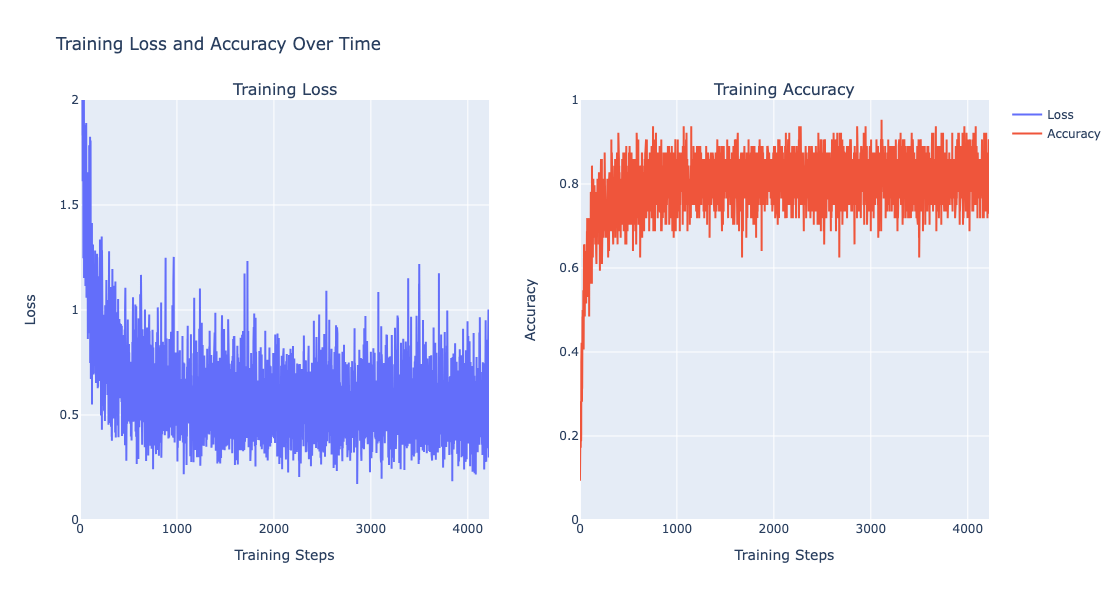

In [26]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Training Loss", "Training Accuracy"))

# Adding the Loss plot
fig.add_trace(
    go.Scatter(y=batch_stats_callback.batch_losses, mode='lines', name='Loss'),
    row=1, col=1
)

# Adding the Accuracy plot
fig.add_trace(
    go.Scatter(y=batch_stats_callback.batch_acc, mode='lines', name='Accuracy'),
    row=1, col=2
)

# Update x-axis labels
fig.update_xaxes(title_text="Training Steps", row=1, col=1)
fig.update_xaxes(title_text="Training Steps", row=1, col=2)

# Update y-axis labels
fig.update_yaxes(title_text="Loss", range=[0, 2], row=1, col=1)
fig.update_yaxes(title_text="Accuracy", range=[0, 1], row=1, col=2)

# Update the layout and size of the figure
fig.update_layout(height=600, width=800, title_text="Training Loss and Accuracy Over Time")

# Show the figure
fig.show()

<a id="task4"></a>
### Task 4 solution

In [27]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 276ms/step - accuracy: 0.8590 - loss: 0.3961
Test Loss: 0.3957649767398834
Test Accuracy: 0.8604000210762024


After training and testing the model, the final metrics for the test set are as follows:

- **Test Loss**: The model achieved a test loss of `0.39`, which indicates the average loss per sample across all testing examples. A lower loss value signifies better performance, suggesting that the model's predictions were relatively close to the actual labels.

- **Test Accuracy**: The model reached an accuracy of `86%` on the test data. This metric shows how often the model correctly predicted the label out of all the test samples. An accuracy of over 87% is quite good, reflecting that the model performed well in recognizing and classifying the test images correctly.
- With a total of 10,000 testing samples, and a batch size of 64, testing involves 157 batches

## Result visualization

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


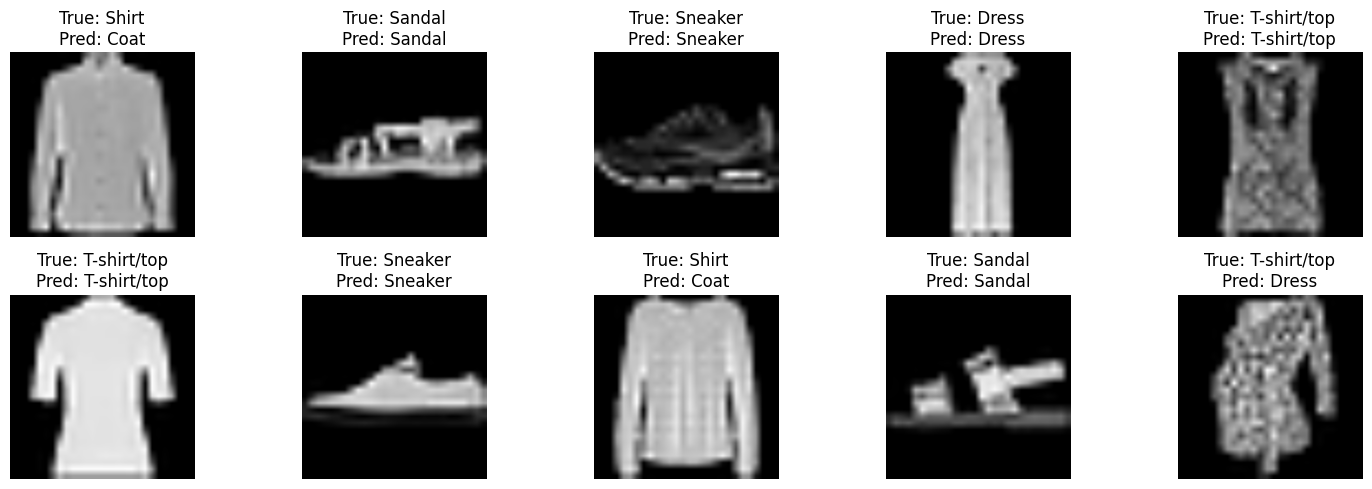

In [28]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def prepare_data(test_dataset, model, num_samples=10):
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)
        return images[:num_samples], true_classes[:num_samples], predicted_classes[:num_samples]


def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray') 
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


images, true_labels, predicted_labels = prepare_data(test_dataset, model, num_samples=10)
images = images.numpy() * 255
images = images.astype('uint8')  

plot_images(images, true_labels, predicted_labels)

### Confusion matrix

In [29]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

confusion_mtx = tf.math.confusion_matrix(labels=y_true, predictions=y_pred, num_classes=10)

print("Confusion Matrix:\n", confusion_mtx.numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

<a id="task5"></a>
### Task 5 solution

In [31]:
model.trainable = True  
total_layers = len(model.layers)
freeze_layers = total_layers - 10  
for layer in model.layers[:freeze_layers]:
    layer.trainable = False


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


history_fine = model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 260s 307ms/step - accuracy: 0.8216 - loss: 0.5118 - val_accuracy: 0.8755 - val_loss: 0.3436
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 249s 295ms/step - accuracy: 0.8276 - loss: 0.4941 - val_accuracy: 0.8773 - val_loss: 0.3393
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 250s 297ms/step - accuracy: 0.8277 - loss: 0.4959 - val_accuracy: 0.8782 - val_loss: 0.3370


Initially, `model.trainable` is set to `True`, making all layers of the model trainable. This change allows the previously frozen base layers of the model to update during training.

  - **Total Layers Count**: We calculate the total number of layers in the model using `len(model.layers)`.
  - **Layers to Freeze**: We then decide to keep the bottom layers of the model frozen (not trainable) except for the last 10 layers. This is done by iterating over each layer up to `total_layers - 10` and setting `layer.trainable = False`. This approach keeps most of the pre-trained knowledge intact while allowing the model to adapt more sophisticated features in its final layers to the new data.
  - **Adam Optimizer**: The optimizer is reconfigured with a much lower learning rate (`1e-5`). This small learning rate ensures that the model's weights are adjusted very subtly during fine-tuning, preventing drastic changes that could destabilize the already learned patterns.
  - **Loss and Metrics**: The model continues to use categorical crossentropy as its loss function, which is suitable for multi-class classification tasks, and accuracy as the metric to track model performance.
  - After adjusting the model's layers and setting up the new optimizer, the model is re-compiled.
  - **Training Process**: The model is then fine-tuned for an additional 3 epochs using the adjusted training configuration, including both the train dataset and the validation dataset to monitor improvement.

### Model  Evaluation

In [32]:
evaluation = model.evaluate(test_dataset)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 272ms/step - accuracy: 0.8781 - loss: 0.3426
Test Loss: 0.3467228412628174
Test Accuracy: 0.8784999847412109


After reducing the learning rate during the fine-tuning phase, the model's performance showed slight improvements:
- **Loss**: The loss decreased from `0.39` to `0.34`. This reduction indicates that the model is performing slightly better in terms of minimizing the error between predicted outputs and true values.
- **Accuracy**: There was a 1% increase in accuracy, from `86%` to `87%`.
  
While the improvements are promising, the changes are relatively minor. This outcome suggests that while the tweak to the learning rate has had a positive effect, further adjustments and experimentation may be necessary to achieve significant enhancements in model performance.

## Visualization

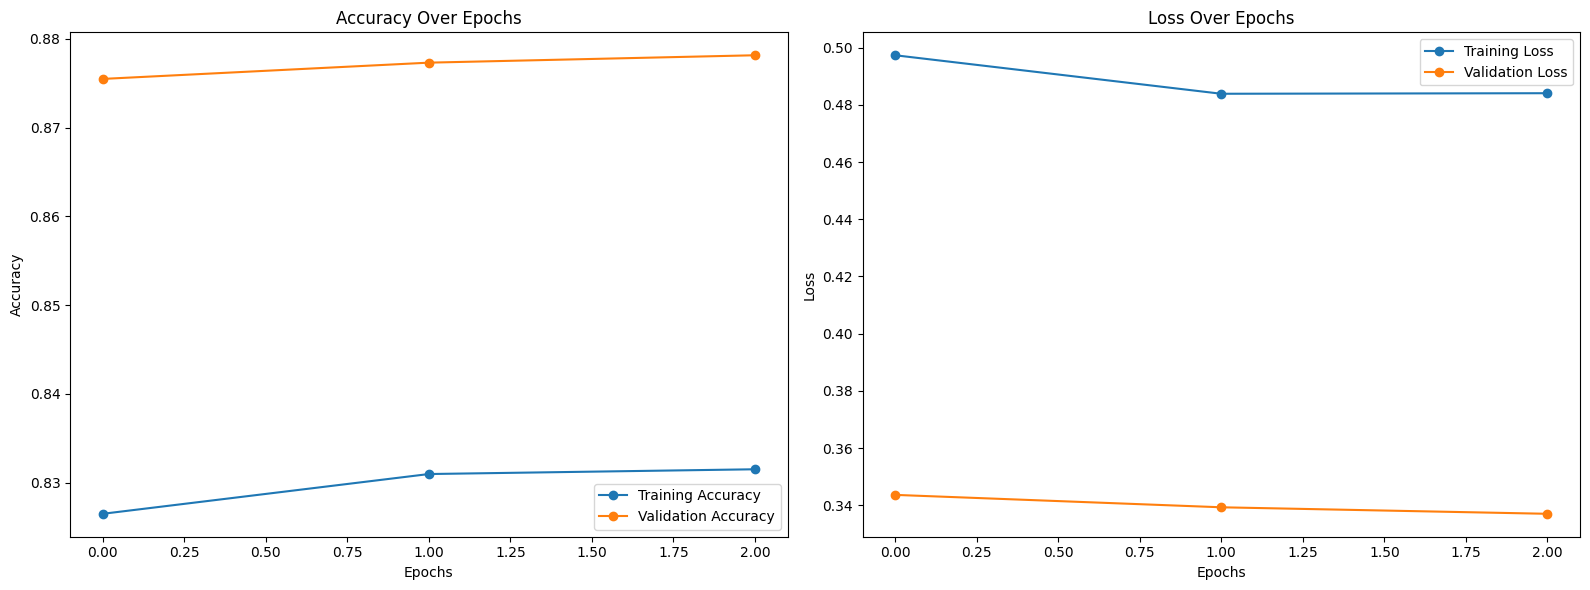

In [33]:
plt.figure(figsize=(16, 6))  

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history_fine.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  
plt.legend() 

# Plot Training and Validation Loss
plt.subplot(1, 2, 2) 
plt.plot(history_fine.history['loss'], label='Training Loss', marker='o')
plt.plot(history_fine.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()  
plt.show()

# Submitted by Anahit Petrosian